# LEARNING BAYESIAN MEDIA MIX MODELLING

In my pursuit to get accustomed to the practical workflow of Bayesian modelling, this notebook is a replica from the analyses ba

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [17]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [2]:
marketing_data = pd.read_csv("marketing-data.csv")
marketing_data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120


# Feature Engineering

Remember we've generated the data ourselves, meaning we're just pretending here. If we'd done the EDA we're supposed to have seen two peaks in the `sales` that meant there were some two - presumably independent - events such as a launch of a new product that led to those two peaks i.e. the week of 13th of May and 14th of September(we can consider including *dummy variables* to indicate these events, but we'll do this on demand). We're also supposed to have seen there's a uniformly increasing trend in sales. These two observations can be seen as `control variables`.
In order to clearly include these into our model, it's wise to engineer features representing them.
- [ ] Let's start with the uniformly increasing trend

In [3]:
marketing_data["trend"] = range(marketing_data.shape[0])

In [4]:
marketing_data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,trend
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120,4


# Model Specification

The first thing to do in Bayesian Analysis Workflow is to state your assumption and place them as priors into your model. Here are the simple heuristics we can think of in our first iteration of the modelling process:
1. Contributions for each channel need to be positive, so we'll use a HalfNormal distribution as our prior distribution. Each HalfNormal distribution requires a $\sigma$ parameter, so we'll use observed means for each channel. This is bad practise as it potentially leads to confirmation bias, but we'll not worry too much about it for now.
2. Secondly, our "expert" opinion expects more sales on weeks when we'd spent more money on either channels. A reasonable assumption indeed.

Apparently, we need our HalfNormal distributions to have unit variance, and to accomplish that, we need to define the scale as:
$$
    \phi = \frac{1}{\sqrt{1 - \frac{2}{\pi}}}
$$
then prior sigmas as:
$$
    \sigma_i = 2\phi\rho_i
$$
where $i = 0, 1$, $\rho$ is each channel's share and $2$ is the number of channels

In [6]:
total_spend_per_channel = marketing_data[["x1", "x2"]].sum(axis=0)
channel_share = total_spend_per_channel / total_spend_per_channel.sum()
channel_share

x1    0.65632
x2    0.34368
dtype: float64

In [8]:
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
n_channels = 2
prior_sigma = HALFNORMAL_SCALE * n_channels * channel_share.to_numpy()
prior_sigma.tolist()

[2.1775326025486734, 1.140260877391939]

In [11]:
# Because the Delayed Saturated MMM follows sklearn convention,
# so we need to split our data into X (predictors) and y(target value)
predictors = marketing_data.drop("y",axis=1)
target = marketing_data["y"]

In [12]:
dummy_model = DelayedSaturatedMMM(
    date_column = "",
    channel_columns= "",
    adstock_max_lag = 4
)

custom_beta_channel_prior = {
    "beta_channel": {
        "sigma": prior_sigma,
        "dims": ("channel",)
    }
}

my_model_config = {
    **dummy_model.default_model_config,
    **custom_beta_channel_prior
}

In [13]:
sampler_config= {"progressbar": True}

In [15]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "trend",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

# Model Fitting

In [18]:
mmm.fit(X=predictors, y=target, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 250 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

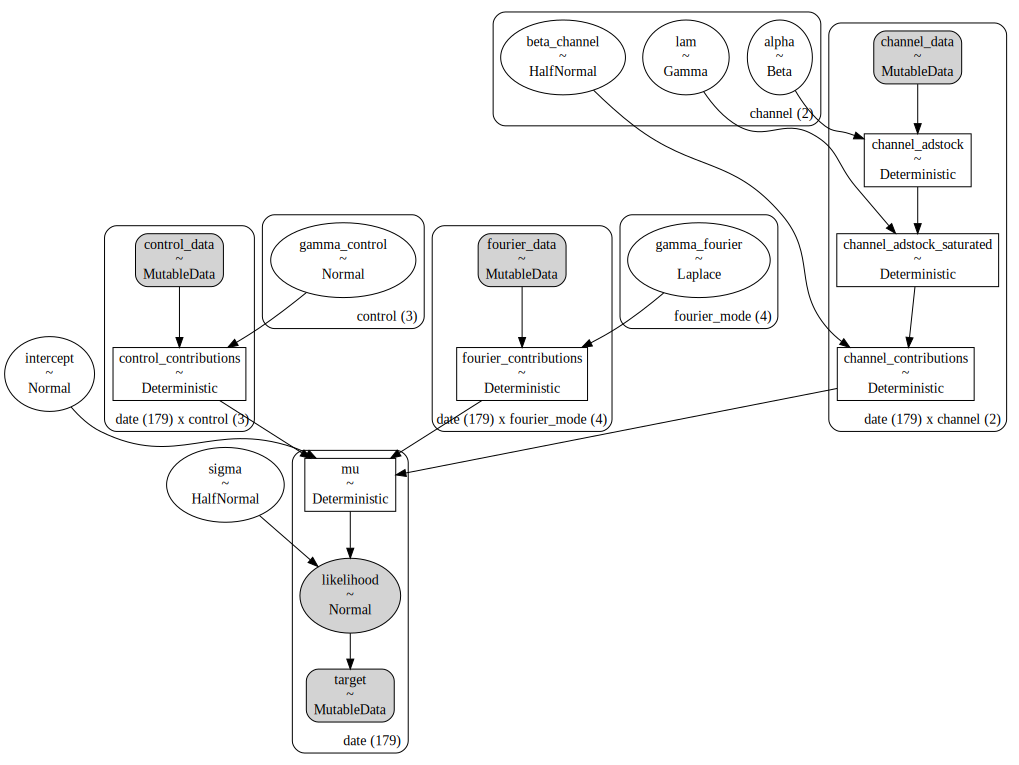

In [19]:
pm.model_to_graphviz(model=mmm.model)